In [1]:
import json
import matplotlib.pyplot as plt
from collections import Counter
import numpy as np

In [4]:
def get_motifs(teams, data_match):
    list_of_possessions = []
    temp = []
    poss_team = data_match[0]['possession_team']['id']
    for i, event in enumerate(data_match):
        if event['possession_team']['id'] == poss_team:
            temp.append((i, event['type']['name']))
        else:
            list_of_possessions.append(temp)
            temp = []
            poss_team = event['possession_team']['id']
            temp.append((i, event['type']['name']))

    sequences = []
    temp = []

    letters = ['A', 'B', 'C', 'D']

    for possesion in list_of_possessions:
        for i, event in enumerate(possesion):
            if event[1] == 'Pass':
                temp.append(event)
            else:
                if i < len(possesion)-1 and sequence_still_going(event[1], possesion[i+1][1]) and len(temp) > 0:
                    temp.append(event)
                else:
                    if len(temp) > 0:
                        sequences.append(temp)
                        temp = []
                    temp = []

    combos = {}
    for team in teams:
        combos[team] = []

    for seq in sequences:
        passes_only = []
        for elem in seq:
            if elem[1] == 'Pass':
                passes_only.append(elem)
        if len(passes_only) >= 3:
            for i in range(len(passes_only)-3, -1, -1):
                players_involved = []
                players_string = ''
                for k, passaggio in enumerate(passes_only[i:i+3]):
                    player_id = data_match[passaggio[0]]['player']['id']
                    if not player_id in players_involved:
                        players_involved.append(player_id)
                        players_string += letters[len(players_involved)-1]
                    else:
                        players_string += letters[players_involved.index(
                            player_id)]

                    if k == 2:
                        # print(data_match[passaggio[0]]['pass'])
                        if 'recipient' in data_match[passaggio[0]]['pass'].keys():
                            final_player = data_match[passaggio[0]
                                                      ]['pass']['recipient']['id']
                            if not final_player in players_involved:
                                players_involved.append(final_player)
                                players_string += letters[len(
                                    players_involved)-1]
                            else:
                                players_string += letters[players_involved.index(
                                    final_player)]
                        else:
                            players_string = ''
                if len(players_string) > 0:
                    for team in teams:
                        if data_match[passes_only[i][0]]['possession_team']['name'] == team:
                            combos[team].append(players_string)

    return combos


In [3]:

def sequence_still_going(last_event, new_event):
    diz = {'Pass': ['Ball Receipt*'],
           'Ball Receipt*': ['Pass', 'Carry'], 'Carry': ['Pass']}
    if last_event in diz.keys():
        return new_event in diz[last_event]
    return False


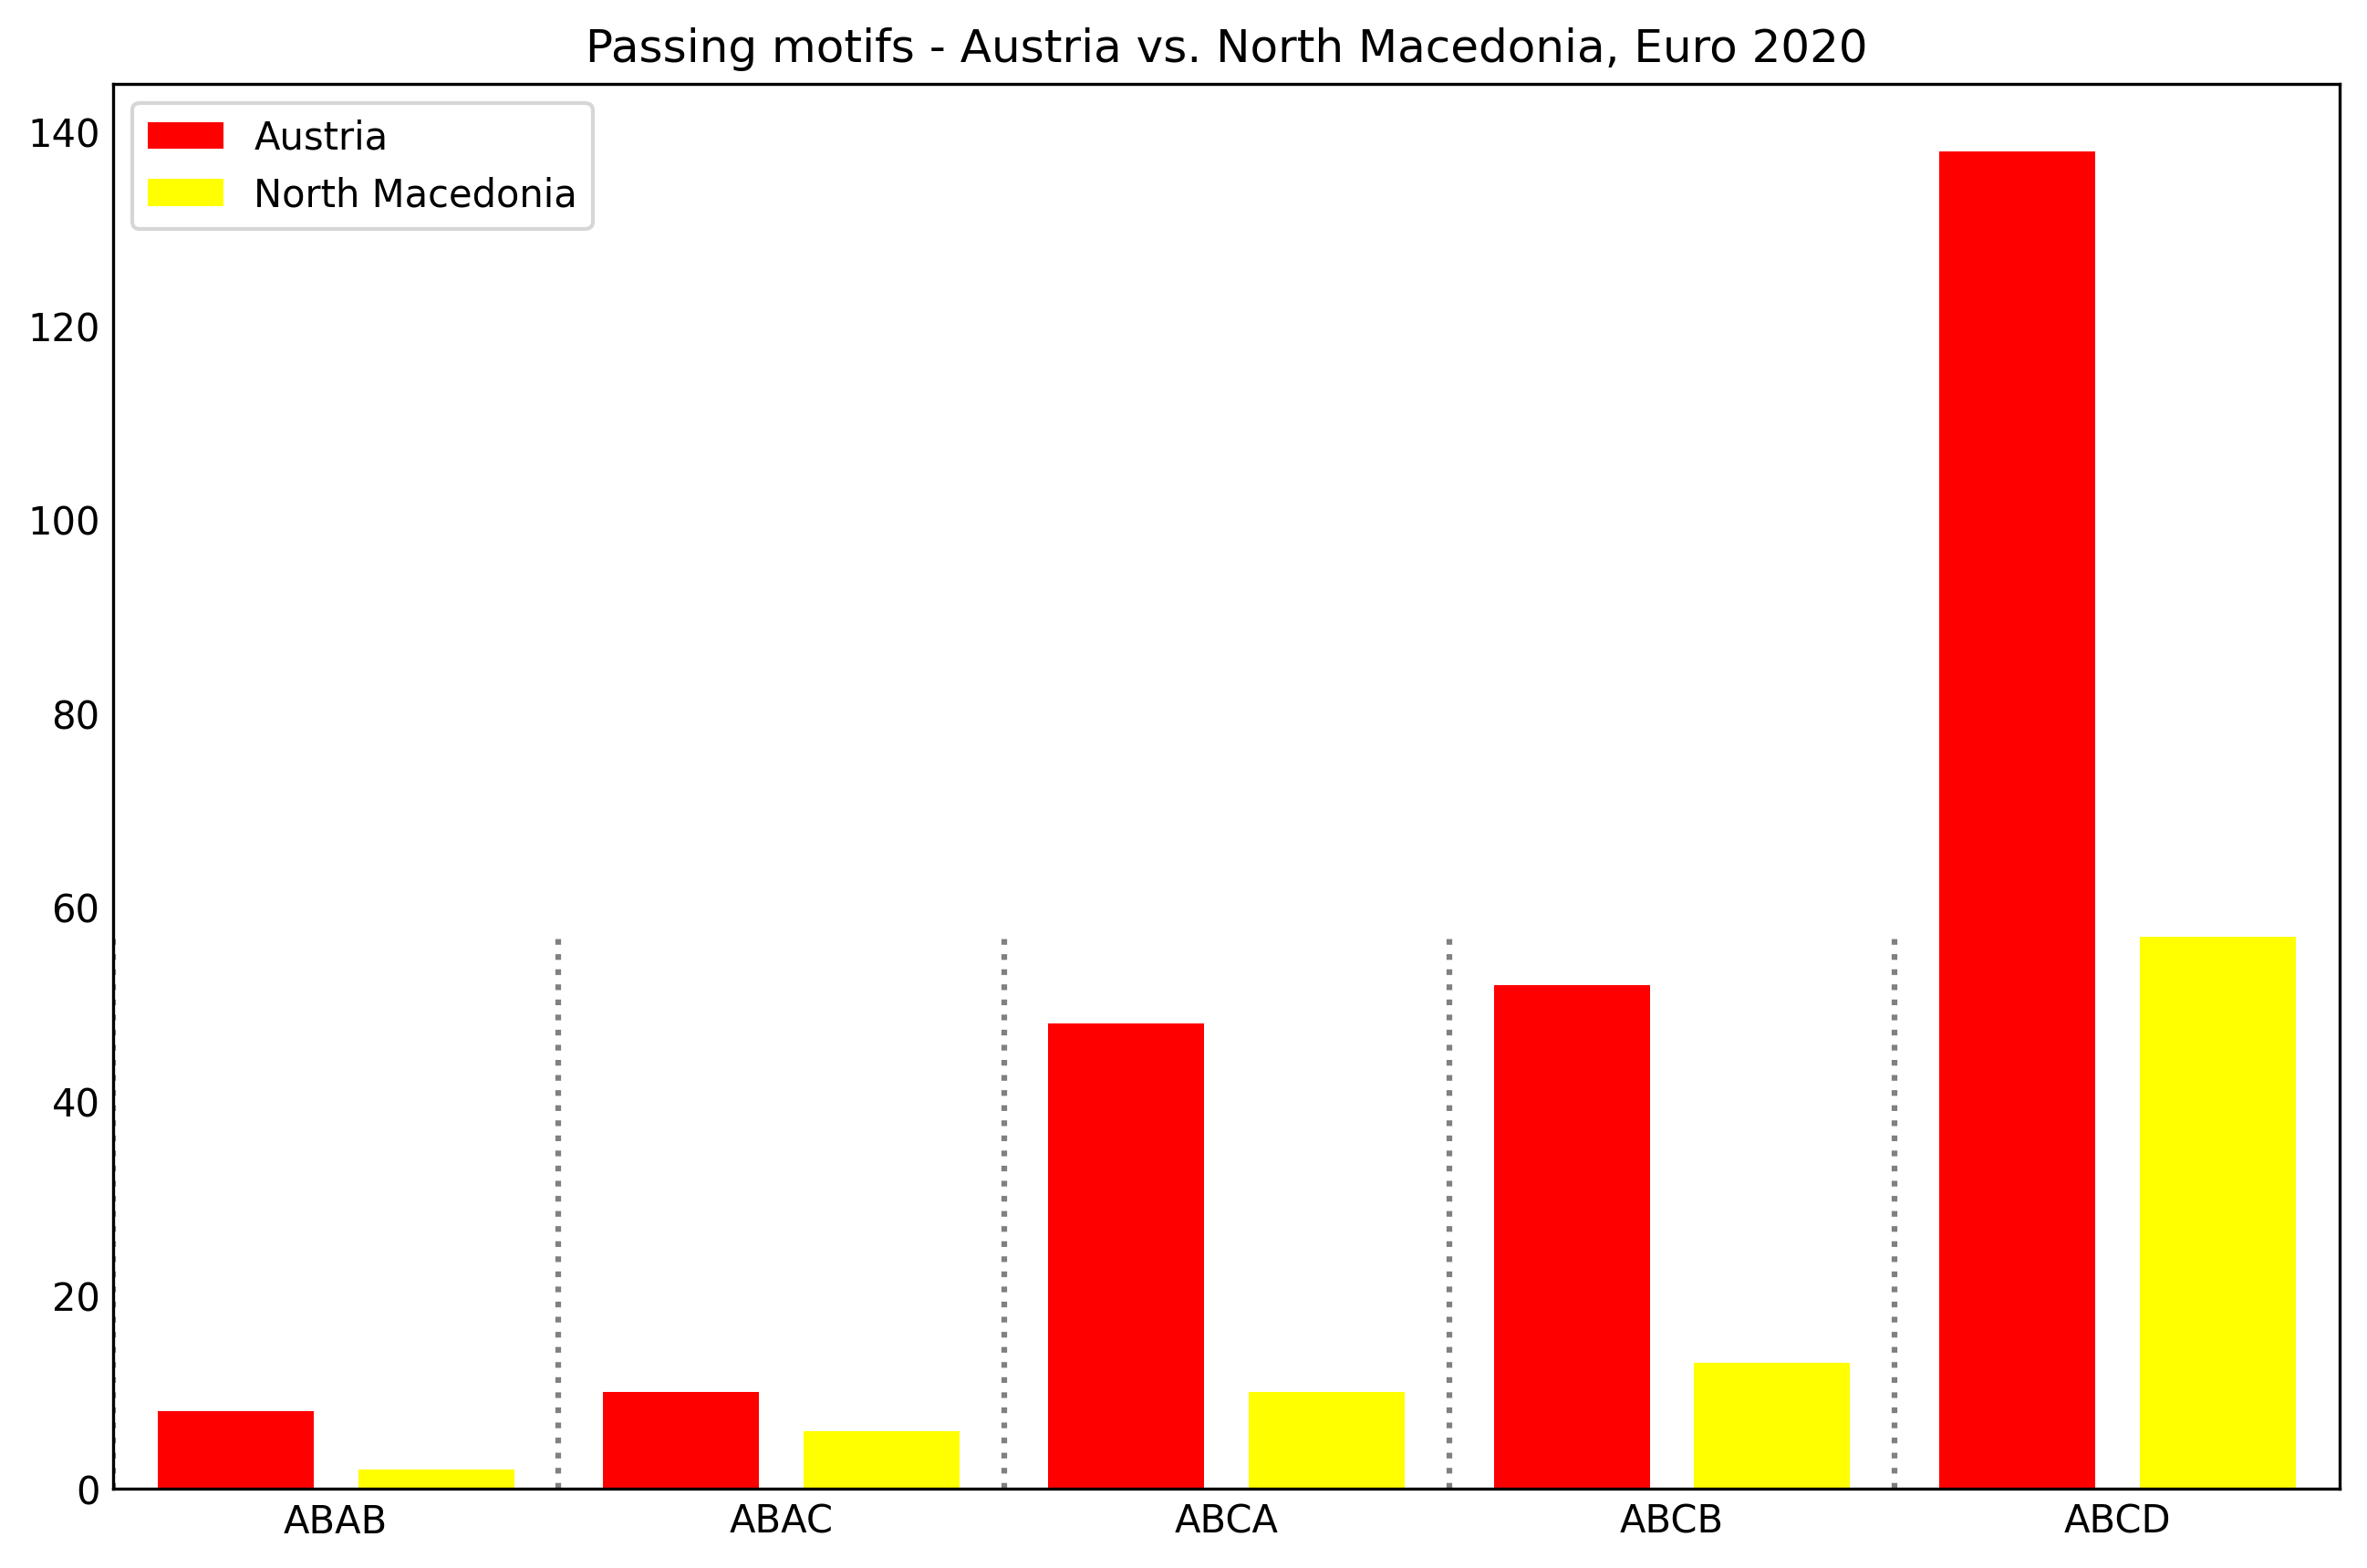

In [12]:


# TODO: write the path to your StatBomb's game events json file
statsbomb_file_path = "../../data/statsbomb360/events/3788747.json"

with open(statsbomb_file_path) as file_match:
    data_match = json.load(file_match)

teams = [data_match[0]["team"]["name"], data_match[1]["team"]["name"]]

combos = get_motifs(teams, data_match)
combos_count = {}


all_combos = set()
for team in teams:
    combos_count[team] = Counter(combos[team])
    for k, v in combos_count[team].items():
        all_combos.add(v)
    for t in teams:
        for v in all_combos:
            combos_count.setdefault(t, 0)

labels = sorted(combos_count[teams[0]])
data_teams = {}
i = 0
for team in teams:
    data_teams[team] = sorted(combos_count[team].values())

fig, ax = plt.subplots(figsize=(10.5, 6.8), dpi=300)
i = 0

# TODO: Set the color for the playing teams
color = {
    "Austria": "red",
    "North Macedonia": "yellow"
}
s = .1
w = (1-s)/len(teams)-s
ymax = 0
for team in teams:
    ymax = max(0, max(data_teams[team]))
    ax.bar(np.arange(len(labels))+(s+w)*i+s,
           data_teams[team], width=w, label=team, align="edge", color=color[team])
    i += 1

ax.set_title("Passing motifs - Austria vs. North Macedonia, Euro 2020")
ax.vlines(np.arange(len(labels)), 0, ymax, color="grey", linestyle="dotted")
ax.tick_params(axis=u'both', which=u'both', length=0)
ax.set_xticks(np.arange(len(labels))+1/2, labels=labels)
ax.set_xlim([0, len(labels)])
plt.legend()
plt.show()

fig.savefig("../../upload/passing/passing_motifs.png", dpi=300)
